In [2]:
import os
import scipy.io
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

In [3]:
class CustomMatDataset(Dataset):
    def __init__(self, ch_dir, f_dir, w_dir):
        self.ch_files = [os.path.join(ch_dir, file) for file in os.listdir(ch_dir) if file.endswith('.mat')]
        self.f_dir = f_dir
        self.w_dir = w_dir
    def __len__(self):
        return len(self.ch_files)

    def __getitem__(self, idx):
        ch_data = scipy.io.loadmat(self.ch_files[idx])['H']
       
        f_file = self.f_dir+'/'+"fopt_"+self.ch_files[idx].split('/')[6].split('new_')[1].split('.')[0] + '.mat'
        w_file = self.w_dir+'/'+"wopt_"+self.ch_files[idx].split('/')[6].split('new_')[1].split('.')[0] + '.mat'
        ch_data = ch_data.reshape(5, 36, 144)
        ch = np.zeros((1, 5, 36, 288))
        ch[:,:,:,:144] = np.real(ch_data)
        ch[:,:,:, 144:288] = np.imag(ch_data)
        ch_data = ch
        
        
        f_data = scipy.io.loadmat(f_file)['Fopt_final']
        f_data = f_data.reshape((5, 144, 2))
        f = np.zeros((1, 5, 144, 4))
        f[:,:,:, :2] = np.real(f_data)
        f[:,:,:,2:4] = np.imag(f_data)
        f_data = f
        
        w_data = scipy.io.loadmat(w_file)['Wopt_final']
        w_data = w_data.reshape((5, 36, 2))
        w = np.zeros((1, 5, 36, 4))
        w[:,:,:, :2] = np.real(w_data)
        w[:,:,:,2:4] = np.imag(w_data)
        w_data = w
        data = np.zeros((1, 5, 180, 4))
        data[:,:,:144,:] = f_data
        data[:,:,144:180,:] = w_data
        
        
        return torch.tensor(ch_data, dtype=torch.float32), torch.tensor(data, dtype=torch.float32)


In [4]:
# Define directories
ch_dir = '/kaggle/input/dataset-hfw/Combined Dataset/Input'
f_dir = '/kaggle/input/dataset-hfw/Combined Dataset/Output1'
w_dir = '/kaggle/input/dataset-hfw/Combined Dataset/Output2'

# Create dataset
dataset = CustomMatDataset(ch_dir, f_dir, w_dir)

# Split dataset into train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [5]:
for ch, f in train_loader:
    print(ch.shape, f.shape)
    
    break

torch.Size([4, 1, 5, 36, 288]) torch.Size([4, 1, 5, 180, 4])


In [6]:
import torch
import torch.nn as nn

class AttentionBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(AttentionBlock, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(embed_dim, embed_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        #print(x.shape)
        xs = x.shape
        x = x.view(-1, 144, 36)
        print(x.shape)
        # Assume x is of shape (batch_size, seq_length, embed_dim)
        attn_output, _ = self.multihead_attn(x, x, x)
        x = self.layer_norm(x + self.dropout(attn_output))
        print(x.shape)
        x = self.fc(x)
        x = self.activation(x)
        x = x.view(xs[0], xs[1], xs[2], xs[3], xs[4])
        return x

# Parameters
batch_size = 4
dim1 = 2
dim2 = 5
seq_length = 144
embed_dim = 36  # Embedding dimension must match the last dimension of the input
num_heads = 6  # Number of attention heads

# Initialize the AttentionBlock
attention_block = AttentionBlock(embed_dim, num_heads)

# Example input tensor
input_tensor = torch.randn(batch_size, dim1, dim2, seq_length, embed_dim)

# Reshape the input tensor to (batch_size * dim1 * dim2, seq_length, embed_dim)
reshaped_input = input_tensor.view(-1, seq_length, embed_dim)

# Pass the reshaped input through the attention block
output = attention_block(input_tensor)

# Reshape the output back to the original dimensions
#output = output.view(batch_size, dim1, dim2, seq_length, embed_dim)

print(output.shape)  # Should match the input shape: (4, 2, 5, 144, 36)


torch.Size([40, 144, 36])
torch.Size([40, 144, 36])
torch.Size([4, 2, 5, 144, 36])


In [7]:
import torch
import torch.nn as nn

class Res(nn.Module):
    def __init__(self, in_channels):
        super(Res, self).__init__()
        
        self.conv1 = nn.Conv3d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(in_channels)

    def forward(self, x):
        identity = x  # Skip connection

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity  # Add the skip connection
        out = self.relu(out)

        return out

# Example usage
input_tensor = torch.randn(4, 1, 5, 36, 288)  # (batch_size, channels, depth, height, width)
residual_block = Res(in_channels=1)

output_tensor = residual_block(input_tensor)
print(output_tensor.shape)  # Should match the input shape: (4, 2, 5, 144, 36)


torch.Size([4, 1, 5, 36, 288])


In [8]:
import torch.nn as nn
class ResidualBlock(nn.Module):
    def __init__(self):
        super(ResidualBlock, self).__init__()
        self.attn1 = AttentionBlock(36, 6)
        self.res1 = Res(2)
        self.conv1 = nn.Conv3d(2, 32, (1,3 ,3), padding = (1, 1, 0))
        self.pool1 = nn.MaxPool3d((1, 3, 3))
        self.norm1 = nn.BatchNorm3d(32)
        self.conv2 = nn.Conv3d(32, 64, (1, 3, 3), padding = (1, 1, 0))
        self.norm2 = nn.BatchNorm3d(64)
        self.pool2 = nn.MaxPool3d((2,1 ,2))
        self.conv3 = nn.Conv3d(64, 128, (1, 3, 3), padding = (1, 1, 0))
        self.norm3 = nn.BatchNorm3d(128)
        self.pool3 = nn.MaxPool3d((2, 1, 2 ))
        self.conv4 = nn.Conv3d(128, 2, (1, 1, 1), padding = (1, 1, 0))
        self.norm4 = nn.BatchNorm3d(2)
        self.pool4 = nn.MaxPool3d((2, 1, 2 ))
     
        
        self.lin1 = nn.Linear(1600, 3600)
        self.actv1 = nn.Tanh()
        self.actv2 = nn.Tanh()
        
    def forward(self, x):
        x = x.view(-1, 2, 5, 144, 36)
        x = self.attn1(x)
        x = self.res1(x)
        
        c1 = self.conv1(x)
        c1 = self.pool1(c1)
        c1 = self.norm1(c1)
        c1 = self.actv1(c1)
        
        
        c2 = self.conv2(c1)
        c2 = self.pool2(c2)
        c2 = self.norm2(c2)
        c2 = self.actv2(c2)
        
        c3 = self.conv3(c2)
        c3 = self.norm3(c3)
        #c3 = self.pool3(c3)
        c3 = self.actv1(c3)
        c4 = self.conv4(c3)
        c4 = self.norm4(c4)
        #c3 = self.pool3(c3)
        c4 = self.actv1(c4)
        
       
        c4 = torch.flatten(c4, 1)
        #print(c4.shape)
        c4 = self.lin1(c4)
        c4 = c4.view(-1, 1, 5, 180, 4)
        c4 = self.actv1(c4)
        
        
        return c4

In [9]:
device = 'cuda'
model = ResidualBlock()
model = model.to('cuda')
class HuberLoss(nn.Module):
    def __init__(self, delta=1.0):
        super().__init__()
        self.delta = delta

    def forward(self, y_true, y_pred):
        error = y_true - y_pred
        condition = torch.abs(error) <= self.delta
        small_res = 0.5 * error**2
        large_res = self.delta * (torch.abs(error) - 0.5 * self.delta)
        return torch.where(condition, small_res, large_res).mean()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [10]:
x = torch.rand((3,1, 5, 36, 288)).to(device).float()
model(x).shape

torch.Size([30, 144, 36])
torch.Size([30, 144, 36])


torch.Size([3, 1, 5, 180, 4])

In [11]:

from tqdm import tqdm

In [12]:
import matplotlib.pyplot as plt

# Extract one batch from the train loader
inputs, targets = next(iter(train_loader))
targets = torch.real(targets)
# Select one example (e.g., the first one in the batch)
example_fopt = targets[0]  # Shape: [5, 144, 2]

# Select one channel (e.g., the first channel)
selected_channel = example_fopt[0]  # Shape: [144, 2]
selected_channel = selected_channel.reshape((15,24, 2))
selected_channel = selected_channel[:, :, 0] + selected_channel[:, :, 1]*1j
selected_channel = abs(selected_channel)
print(selected_channel.shape)
# Plot the selected channel
fig, axs = plt.subplots(1, 2, figsize=(6, 4))
axs[0].imshow(selected_channel, aspect='auto', origin='lower', cmap='turbo')
axs[0].set_title('Input')


axs[1].imshow(selected_channel, aspect='auto', origin='lower', cmap='turbo')
axs[1].set_title('Predicted')


# Plot clean STFT magnitude

plt.tight_layout()
plt.show()

RuntimeError: shape '[15, 24, 2]' is invalid for input of size 3600

In [13]:
# Training loop
best_loss = 99
t_l, v_l = [],[]
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 3000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in tqdm(train_loader):
        inputs = inputs.to(device).float()
        targets = targets.to(device).float()
        optimizer.zero_grad()
        outputs = model(inputs)
        #print(outputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')
    t_l.append(running_loss/len(train_loader))

    # Evaluate the model
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader):
            inputs = inputs.to(device).float()
            targets = targets.to(device).float()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            
        
 
    print(f'Test Loss: {test_loss/len(test_loader)}')
    v_l.append(test_loss/len(test_loader))
    if test_loss/len(test_loader) <best_loss:
        best_loss = test_loss/len(test_loader)
        torch.save(model,"/kaggle/working/model.pth")
        print("<_________________________Model_saved__________________________>")
        

  0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([40, 144, 36])
torch.Size([40, 144, 36])


  1%|          | 3/500 [00:01<04:02,  2.05it/s]

torch.Size([40, 144, 36])
torch.Size([40, 144, 36])
torch.Size([40, 144, 36])
torch.Size([40, 144, 36])


  1%|          | 4/500 [00:02<03:34,  2.31it/s]

torch.Size([40, 144, 36])
torch.Size([40, 144, 36])


  1%|          | 5/500 [00:02<03:15,  2.53it/s]

torch.Size([40, 144, 36])
torch.Size([40, 144, 36])


  1%|▏         | 7/500 [00:02<02:20,  3.51it/s]

torch.Size([40, 144, 36])
torch.Size([40, 144, 36])
torch.Size([40, 144, 36])
torch.Size([40, 144, 36])


  2%|▏         | 8/500 [00:03<02:32,  3.22it/s]

torch.Size([40, 144, 36])
torch.Size([40, 144, 36])
torch.Size([40, 144, 36])


  2%|▏         | 9/500 [00:03<02:15,  3.62it/s]

torch.Size([40, 144, 36])


  2%|▏         | 11/500 [00:03<01:49,  4.48it/s]

torch.Size([40, 144, 36])
torch.Size([40, 144, 36])
torch.Size([40, 144, 36])
torch.Size([40, 144, 36])


  2%|▏         | 12/500 [00:04<02:12,  3.67it/s]

torch.Size([40, 144, 36])
torch.Size([40, 144, 36])


  3%|▎         | 13/500 [00:04<02:14,  3.62it/s]

torch.Size([40, 144, 36])
torch.Size([40, 144, 36])


  3%|▎         | 14/500 [00:04<02:32,  3.19it/s]

torch.Size([40, 144, 36])
torch.Size([40, 144, 36])


  3%|▎         | 15/500 [00:05<02:26,  3.32it/s]

torch.Size([40, 144, 36])
torch.Size([40, 144, 36])


  3%|▎         | 17/500 [00:05<02:00,  4.01it/s]

torch.Size([40, 144, 36])
torch.Size([40, 144, 36])
torch.Size([40, 144, 36])
torch.Size([40, 144, 36])


  4%|▍         | 19/500 [00:05<01:34,  5.10it/s]

torch.Size([40, 144, 36])
torch.Size([40, 144, 36])
torch.Size([40, 144, 36])
torch.Size([40, 144, 36])


  4%|▍         | 20/500 [00:05<01:26,  5.53it/s]

torch.Size([40, 144, 36])
torch.Size([40, 144, 36])


  4%|▍         | 22/500 [00:06<01:34,  5.07it/s]

torch.Size([40, 144, 36])
torch.Size([40, 144, 36])
torch.Size([40, 144, 36])
torch.Size([40, 144, 36])


  5%|▍         | 24/500 [00:06<01:38,  4.84it/s]

torch.Size([40, 144, 36])
torch.Size([40, 144, 36])
torch.Size([40, 144, 36])
torch.Size([40, 144, 36])


  5%|▌         | 26/500 [00:07<01:21,  5.81it/s]

torch.Size([40, 144, 36])
torch.Size([40, 144, 36])
torch.Size([40, 144, 36])
torch.Size([40, 144, 36])


  5%|▌         | 27/500 [00:07<02:09,  3.66it/s]

torch.Size([40, 144, 36])
torch.Size([40, 144, 36])


KeyboardInterrupt: 

In [ ]:
plt.plot(t_l)
plt.plot(v_l)
plt.show()

In [15]:
def save_mat(path, f_out_file, w_out_file, model):
    model = model#torch.load("/kaggle/working/model.pth").to(device)
    ch_data = scipy.io.loadmat(path)['H']
    ch_data = ch_data.reshape(5, 36, 144)
    ch = np.zeros((5, 36, 144, 2))
    ch[:,:,:, 0] = np.real(ch_data)
    ch[:,:,:, 1] = np.imag(ch_data)
    ch_data = torch.tensor(ch.reshape(1, 5, 36, 144, 2)).to('cuda').float()
    ch_data = ch_data.to('cuda')
    out = model(ch_data*1e6)
    print(out.shape)
    out = out.detach().cpu().numpy()
    
    out = out.reshape((180, 4, 5))
    f_out = out[:144, :2, :] + 1j* out[:144, 2:4, :]
    w_out = out[144:180,:2, :] + 1j* out[144:180,2:4, :]
    
    scipy.io.savemat(w_out_file, {"W": w_out})
    scipy.io.savemat(f_out_file, {"F": f_out})
    
    print(w_out.shape, f_out.shape)
import time
st = time.time()
in_file = "/kaggle/input/dataset-hfw/Combined Dataset/Input/new_u_10_102_253_468_412.mat"
w_out_file = "WPRED_u_10_102_253_468_412.mat"
f_out_file = "FPRED_u_10_102_253_468_412.mat"
save_mat(in_file, f_out_file, w_out_file, model)
sp = time.time()
print(sp-st)
    
    
    
    
    

torch.Size([10, 144, 36])
torch.Size([10, 144, 36])
torch.Size([1, 1, 5, 180, 4])
(36, 2, 5) (144, 2, 5)
0.054680585861206055


In [40]:
for i, j in train_loader:
    print(torch.min(abs(j)))
    break

tensor(0.)


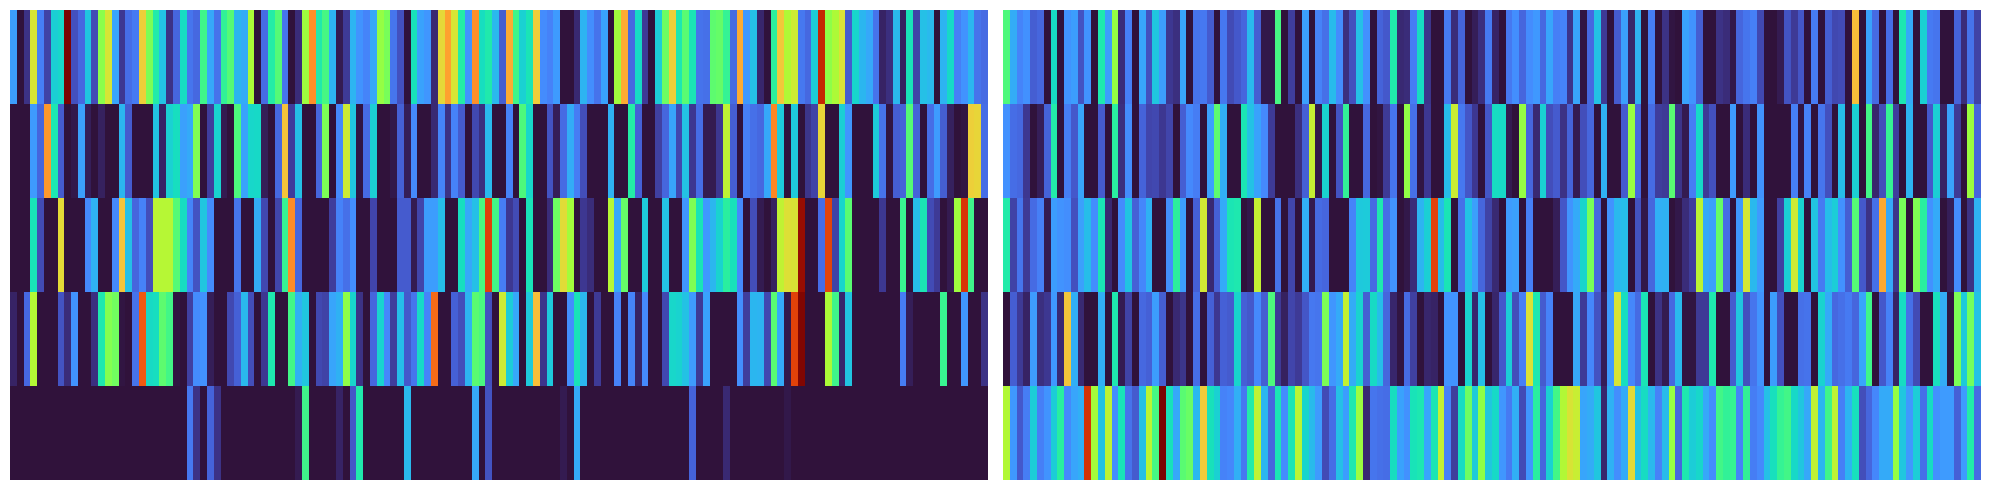

In [53]:
def get_feature_maps(model, layer_name):
    activations = {}
    def hook(model, input, output):
        activations[layer_name] = output.detach()
    handle = getattr(model, layer_name).register_forward_hook(hook)
    return activations, handle

# Assume `model` is your CNN and `input_data` is your prepared input
layer_name = 'res1'  # Example layer name
activations, handle = get_feature_maps(model, layer_name)
input_data = torch.rand((4, 5, 144, 36, 2))
# Make a forward pass through the model
output = model(input_data.to(device))

# `activations` now contains the feature maps from `layer_name`
feature_maps = activations[layer_name]

# Don't forget to remove the hook
handle.remove()
feature_maps_batch = feature_maps[0]

num_filters = feature_maps_batch.shape[0]
num_columns = min(num_filters, 3)  # How many columns of subplots in the figure

# Handling the creation of subplots for both single and multiple axes
fig, axes = plt.subplots(1, num_columns, figsize=(20, 5))

if num_columns == 1:
    axes = [axes]  # If only one subplot, put it in a list to make it iterable

for i, ax in enumerate(axes):
    # Squeeze to remove channel dimension and convert to numpy for plotting
    fmap = feature_maps_batch[i][:,:,0].squeeze().cpu().numpy()
    ax.imshow(fmap, aspect='auto', cmap='turbo')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [42]:
!pip install torchsummary

In [43]:
from torchsummary import summary
summary(model, input_size=(1, 5, 36, 288))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
MultiheadAttention-1  [[-1, 144, 36], [-1, 20, 20]]               0
           Dropout-2              [-1, 144, 36]               0
         LayerNorm-3              [-1, 144, 36]              72
            Linear-4              [-1, 144, 36]           1,332
              ReLU-5              [-1, 144, 36]               0
    AttentionBlock-6        [-1, 2, 5, 144, 36]               0
            Conv3d-7        [-1, 2, 5, 144, 36]             110
       BatchNorm3d-8        [-1, 2, 5, 144, 36]               4
              ReLU-9        [-1, 2, 5, 144, 36]               0
           Conv3d-10        [-1, 2, 5, 144, 36]             110
      BatchNorm3d-11        [-1, 2, 5, 144, 36]               4
             ReLU-12        [-1, 2, 5, 144, 36]               0
              Res-13        [-1, 2, 5, 144, 36]               0
           Conv3d-14       [-1, 32,

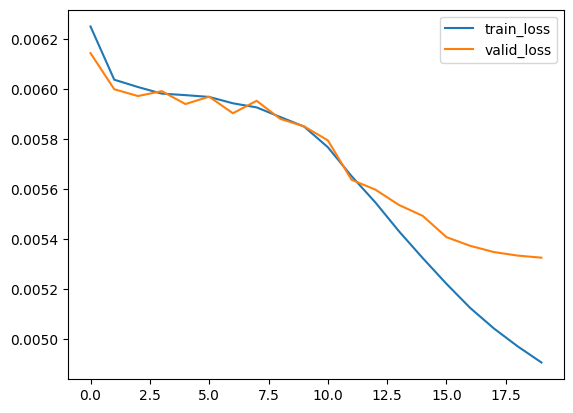

In [57]:
plt.plot(t_l[:20])
plt.plot(v_l[:20])
plt.legend(["train_loss", "valid_loss"] )
plt.show()